In [42]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

In [43]:
class SimpleMultiClassBoosting(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=50):
        self.base_estimator = base_estimator if base_estimator is not None else DecisionTreeClassifier(max_depth=1)
        self.n_estimators = n_estimators
        self.learners = []
        self.learner_weights = []
        self.label_encoder = LabelEncoder()

    def fit(self, X, y):
        Y = self.label_encoder.fit_transform(y)
        n_classes = len(np.unique(Y))
        n_samples = X.shape[0]
        self.weights = (1/n_samples) * np.ones(n_samples, dtype=float)
        for _ in range(self.n_estimators):
            learner = DecisionTreeClassifier(max_depth=1)
            learner.fit(X, Y, sample_weight=self.weights)
            pred = learner.predict(X)
            missClassified = pred != y
            learner_error = np.sum(self.weights[missClassified]) / np.sum(self.weights)
            learner_weight = np.log((1-learner_error) / learner_error) + np.log(n_classes - 1)

            if learner_error >= 1 - (1 / n_classes):
                break

            for idx in range(n_samples):
                if missClassified[idx] == True:
                    self.weights[idx] *= np.exp(learner_weight)    
            self.weights /= np.sum(self.weights)    
            self.learners.append(learner)
            self.learner_weights.append(learner_weight)

    def predict(self, X):
        predictionsOfLearners = []
        for learner in self.learners:
            predictionsOfLearners.append(learner.predict(X))
        predictionsOfLearners = np.array(predictionsOfLearners)
        prediction = np.empty(X.shape[0])        
        for i in range(X.shape[0]):
            labels = np.unique(predictionsOfLearners[:, i])
            votes = {label : 0 for label in labels}
            for j in range(len(predictionsOfLearners[:, i])):
                for label in labels:
                    if predictionsOfLearners[j, i] == label:
                        votes[label] += self.learner_weights[j]
            finalPrediction = max(votes, key=votes.get)
            prediction[i] = self.label_encoder.inverse_transform(np.array([finalPrediction]))
        return prediction


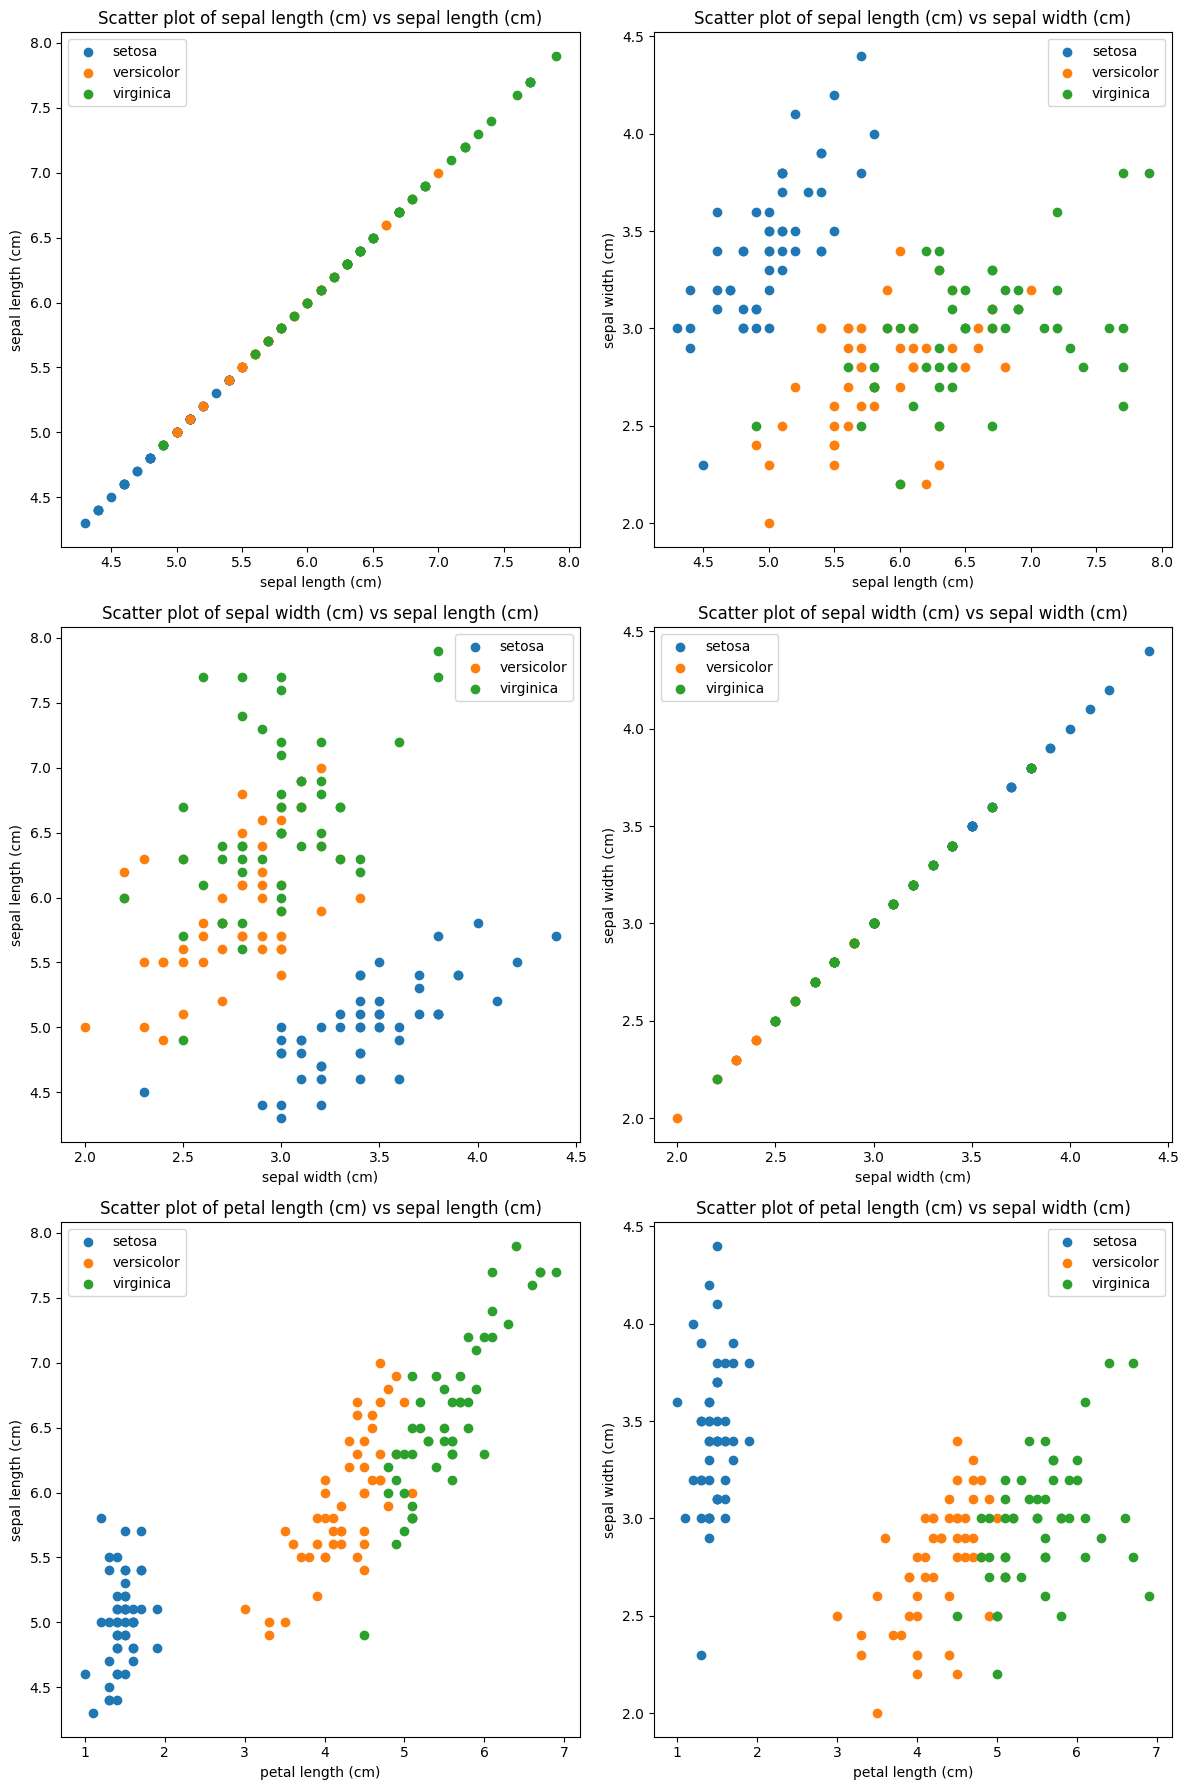

In [44]:
import matplotlib.pyplot as plt
iris = load_iris()
data = iris.data
target = iris.target

feature_names = iris.feature_names

fig, axs = plt.subplots(3, 2, figsize=(12, 18))


for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        for target_class in set(target):
            ax.scatter(data[target == target_class, i], data[target == target_class, j], label=iris.target_names[target_class])
        ax.set_xlabel(feature_names[i])
        ax.set_ylabel(feature_names[j])
        ax.set_title(f'Scatter plot of {feature_names[i]} vs {feature_names[j]}')
        ax.legend()

plt.tight_layout()
plt.show()

In [45]:

X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.3, random_state=42)

In [46]:
m = SimpleMultiClassBoosting()
m.fit(X_train, Y_train)

In [47]:
prediction = m.predict(X_test)

In [48]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [49]:

X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [50]:
m2 = SimpleMultiClassBoosting(n_estimators=3)
m2.fit(X_train, Y_train)
prediction = m2.predict(X_test)
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

